In [1]:
import sys
import cPickle as pickle
from utils.misc import is_flipajs_pc, is_matejs_pc
from core.project.project import Project
import numpy as np
import matplotlib.pylab as plt
import math
import os.path
from core.graph.region_chunk import RegionChunk
from utils.video_manager import get_auto_video_manager
from core.region.transformableregion import TransformableRegion
from core.region.region import get_region_endpoints
import cv2
import fire
import tqdm
import csv
import h5py
import warnings
from itertools import product
from core.interactions.visualization import save_prediction_img
from os.path import join
import pandas as pd
import errno
import hashlib
from utils.img import safe_crop
import pandas as pd

/home/matej/.conda/envs/ferda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
project_dir = '/home/matej/prace/ferda/projects/2_temp/180713_1633_Cam1_clip_initial'

In [3]:
project = Project()
project.load(project_dir)
video = get_auto_video_manager(project)


Initializing db at /home/matej/prace/ferda/projects/2_temp/180713_1633_Cam1_clip_initial/rm.sqlite3 
saving chm
saving GM


In [4]:
def collect_regions(project, params):
    p = params
    from collections import defaultdict
    single = defaultdict(list)
    multi = defaultdict(list)
    # long_moving_tracklets = []
    for tracklet in tqdm.tqdm(project.chm.chunk_gen(), desc='collecting regions', total=len(project.chm)):
        if tracklet.is_single() or tracklet.is_multi():
            region_tracklet = RegionChunk(tracklet, project.gm, project.rm)
            if tracklet.is_single():
                centroids = np.array([region_tracklet.centroid_in_t(frame) for frame
                                      in
                                      range(region_tracklet.start_frame(),
                                            region_tracklet.end_frame())])  # shape=(n,2)

                if len(tracklet) > p['single_min_frames'] and \
                        np.linalg.norm(np.diff(centroids, axis=0), axis=1).mean() > p['single_min_average_speed_px']:
                    # long_moving_tracklets.append(tracklet)

                    regions = list(region_tracklet)
                    # head_fix(regions)
                    
                    # images = []
                    # for region in regions:
                    #     img = video.get_frame(region.frame())
                    #     head, tail = get_region_endpoints(region)
                    #     img = cv2.drawMarker(img, tuple(head[::-1].astype(int)), (0, 0, 255))
                    #     img = cv2.drawMarker(img, tuple(tail[::-1].astype(int)), (0, 255, 0))
                    #     border = 10
                    #     roi = region.roi()
                    #     images.append(img[roi.y() - border:roi.y() + roi.height() + border,
                    #                   roi.x() - border:roi.x() + roi.width() + border])
                    # montage_generator = montage.Montage((1000, 500), (10, 5))
                    # plt.imshow(montage_generator.montage(images[:50])[::-1])
                    # plt.waitforbuttonpress()
                    for region in regions:
                        single[region.frame()].append(region)
                else:
                    # short single tracklets are ignored
                    pass
            else:  # multi
                for region in region_tracklet.regions_gen():
                    # if tracklet.is_single():
                    #     single[region.frame()].append(region)
                    # else:
                    multi[region.frame()].append(region)

    return single, multi

In [27]:
collect_regions_params = {'single_min_frames': 10,
                               'single_min_average_speed_px': 0
                               }
IMAGE_SIZE_PX = 200

In [6]:
single, multi = collect_regions(project, collect_regions_params)

collecting regions: 100%|██████████| 842/842 [00:29<00:00, 28.32it/s]


In [24]:
data = []
for tracklet in project.chm.chunk_gen():
    if len(tracklet) > 10 and tracklet.is_single():
        region_tracklet = RegionChunk(tracklet, project.gm, project.rm)
        centroids = np.array([region_tracklet.centroid_in_t(frame) for frame
                                              in
                                              range(region_tracklet.start_frame(),
                                                    region_tracklet.end_frame())])  # shape=(n,2)
        euclidean_diff = np.linalg.norm(np.diff(centroids, axis=0), axis=1)
        data.append(euclidean_diff)
#     data.append({'mean': euclidean_diff.mean(), 
#                  'median': np.median(euclidean_diff),
#                  '')

In [27]:
euclidean_diff

array([ 1.15,  1.09,  2.56,  1.1 ,  3.97,  1.59,  2.28,  2.9 ,  1.09,  2.28,  2.23,  3.66,  4.81,  5.72,  2.67,  1.55,  3.14,  7.21,  5.09,  0.39,
        2.25,  2.24,  4.11,  5.39,  6.84,  5.67,  8.34, 11.81, 27.96, 31.23, 14.11,  4.02,  2.07,  2.13,  2.16,  2.49,  3.54,  9.11, 16.19, 21.61,
       28.08, 43.44, 45.72, 48.35, 40.76, 18.99, 13.18,  7.71, 36.32, 76.1 , 66.71,  2.56,  0.99,  2.36,  5.23, 12.46, 18.26, 21.32, 20.56, 35.24,
       40.08, 44.32, 34.02, 42.72, 24.87,  8.23, 37.51, 64.29, 64.98, 77.01, 77.95, 87.13, 73.34, 81.23, 53.15, 20.59,  0.81,  1.06,  0.31,  5.53,
       13.31, 15.63,  9.48,  2.58,  1.36,  1.2 ,  0.9 ,  2.04,  2.52,  5.29,  6.19, 15.62, 30.94, 36.08, 23.43, 26.25, 20.1 , 16.84, 24.55, 22.91,
       40.27, 48.37, 65.69, 62.85, 73.  , 70.73, 76.58, 44.05,  4.44,  4.33,  4.84,  4.32, 13.84, 20.79, 27.66, 29.33, 43.84, 22.94, 13.58, 32.84,
       47.33, 70.88, 79.81, 83.86, 73.78, 73.68, 41.9 , 36.78,  2.95,  1.81,  2.5 ,  4.86,  1.63,  0.41,  0.69,  4.81,

In [29]:
df = pd.DataFrame(data).transpose()

In [33]:
stats = df.describe()
stats

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
count,26.000000,115.000000,62.000000,127.000000,18.000000,21.000000,397.000000,85.000000,133.000000,72.000000,...,19.000000,107.000000,380.000000,19.000000,83.000000,686.000000,13.000000,481.000000,43.000000,181.000000
mean,8.535615,2.189780,6.183223,7.335812,1.229060,4.918513,10.310561,1.017078,11.364761,2.417811,...,8.080857,5.864031,7.762201,1.009637,2.939460,6.381017,1.482947,9.229170,6.153292,18.245704
std,6.840944,2.350702,7.670715,7.335252,1.047848,5.343193,11.549856,0.729389,10.734657,2.133929,...,5.424909,6.735194,8.331653,0.703131,3.347673,7.875350,0.895409,8.394542,5.535729,23.267337
min,1.137905,0.134872,0.161339,0.128753,0.058360,0.195255,0.081743,0.046563,0.076509,0.123469,...,1.153273,0.226790,0.074399,0.292667,0.122002,0.052768,0.279403,0.080181,0.631896,0.088551
25%,2.581443,0.898408,0.762115,1.858208,0.419411,1.045115,1.964675,0.484499,2.206356,0.949112,...,2.874655,1.390257,1.499753,0.590239,0.808453,0.789257,0.770074,1.632958,2.390866,2.168580
50%,7.764480,1.472267,1.783680,5.124642,0.895223,2.384250,5.533099,0.919194,6.818327,1.817481,...,7.453633,3.695182,4.716702,0.774330,1.479981,2.278208,1.627668,6.612012,4.102890,5.441147
75%,12.550686,2.619115,12.487425,10.346950,1.696803,7.972912,15.535337,1.408979,20.435550,2.992558,...,11.903187,7.178739,11.694613,1.101816,2.674753,9.841868,2.030439,15.379773,7.960576,27.663647
max,28.466607,14.401931,25.543017,38.168110,3.942751,15.421014,60.646763,3.789673,37.773079,8.610394,...,16.587806,25.748477,42.533638,2.733631,12.270565,37.425685,3.253376,35.945799,23.497905,87.129206


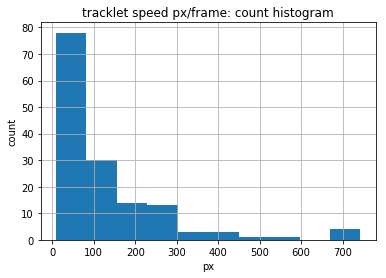

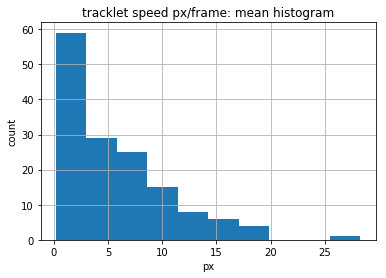

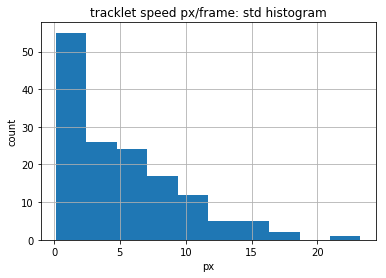

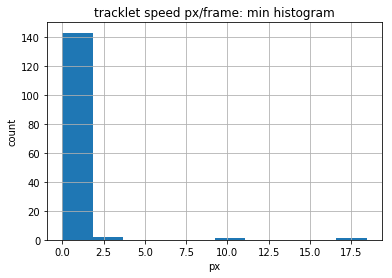

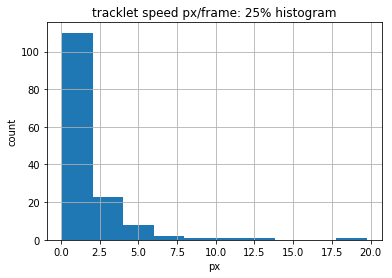

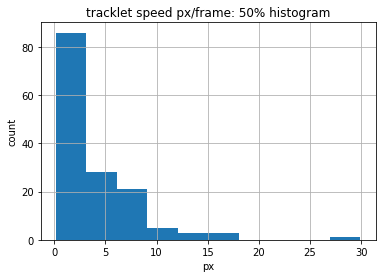

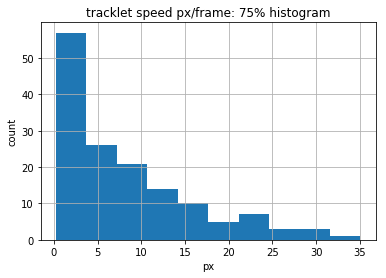

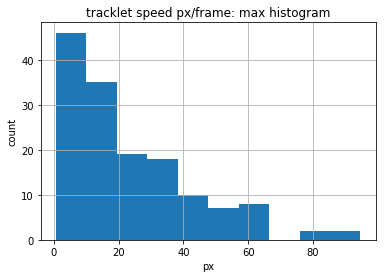

In [45]:
for name, data in stats.iterrows():
    plt.figure()    
    data.hist()
    plt.title('tracklet speed px/frame: ' + name + ' histogram')
    plt.xlabel('px')
    plt.ylabel('count')

In [11]:
single_region_tracklets = []
for tracklet in project.chm.chunk_gen():
    if len(tracklet) > 10 and tracklet.is_single():
        region_tracklet = RegionChunk(tracklet, project.gm, project.rm)
        single_region_tracklets.append(region_tracklet)

In [12]:
import random

In [34]:
IMAGE_SIZE_PX = 150

In [59]:
tracklet = random.choice(single_region_tracklets)
idx1 = np.random.randint(0, len(tracklet) - 1)
images = []
for r in tracklet[idx1:idx1 + 2]:
    img = project.img_manager.get_whole_img(r.frame())
    img_crop, delta_xy = safe_crop(img, tracklet[idx1].centroid()[::-1], IMAGE_SIZE_PX)
    images.append(img_crop)
#     plt.imshow(img_crop)
#     plt.show()

from IPython.display import HTML
from matplotlib import animation

dpi = 72.0
xpixels, ypixels = images[0].shape[0], images[0].shape[1]
fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
im = plt.figimage(images[0])

def animate(i):
    im.set_array(images[i])
    return (im,)

anim = animation.FuncAnimation(fig, animate, frames=len(images), )
# HTML(anim.to_html5_video())
# anim.save('/home/matej/a.mp4')
HTML(anim.to_jshtml(default_mode='loop'))

<Figure size 150x150 with 0 Axes>

In [6]:
from core.interactions.generate_data import DataGenerator

dg = DataGenerator()
random_regions_sorted = dg.write_regression_tracking_data(project_dir, 'x', 'x', count=10)

Initializing db at /home/matej/prace/ferda/projects/2_temp/180713_1633_Cam1_clip_initial/rm.sqlite3 
saving chm
saving GM


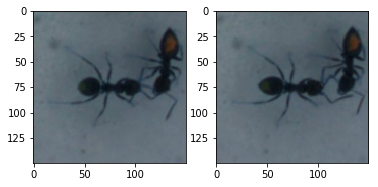

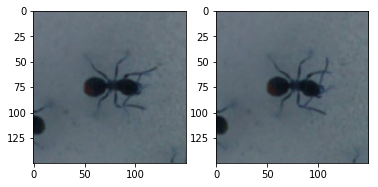

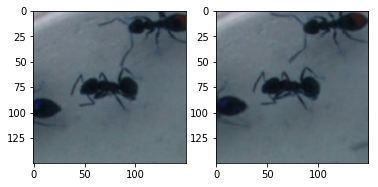

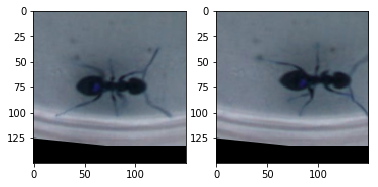

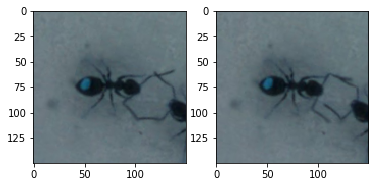

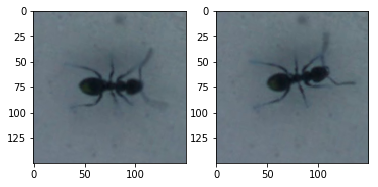

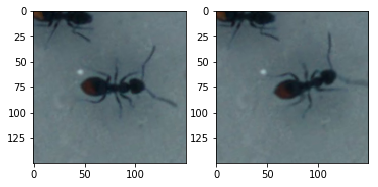

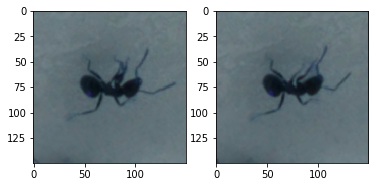

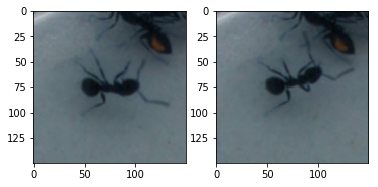

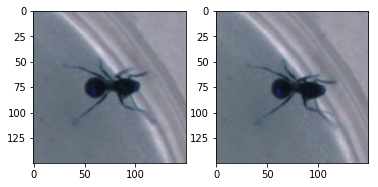

In [7]:
from core.region.transformableregion import TransformableRegion
img_size_px = 150

for regions in random_regions_sorted:
    fig, axes = plt.subplots(1, 2)
    for frame, ax in zip((regions['frame2'] - 1, regions['frame2']), axes):
        img = dg._project.img_manager.get_whole_img(frame)
        # img_crop, delta_xy = safe_crop(img, regions['centroid_xy1'], img_size_px)
        # plt.imshow(img_crop)

        timg = TransformableRegion(img)
        timg.rotate(-np.rad2deg(regions['theta1']), regions['centroid_xy1'][::-1])
        img_rotated = timg.get_img()
        img_crop, delta_xy = safe_crop(img_rotated, regions['centroid_xy1'], img_size_px)
        ax.imshow(img_crop)